# [LAB 03] 계층적 군집 | 튜닝 및 평가

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
from hossam import load_data,my_dpi, visualize_silhouette

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score , silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from kneed import KneeLocator

#성능평가지표
from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram , linkage




### [2] 데이터 가져오기


In [2]:
origin = load_data('iris')
origin.head()

1936년 영국의 통계학자 로널드 피셔(Ronald A. Fisher)가 소개한 3가지 품종(setosa, versicolor, virginica)의 붓꽃(Iris)에 대한 꽃받침과 꽃잎의 길이와 너비 측정값으로 구성된 유명한 머신러닝 및 데이터 분석용 데이터셋.(출처: Kaggle)

field         description
------------  -------------
Sepal.Length  꽃밭침 길이
Sepal.Width   꽃밭침 너비
Petal.Length  꽃잎 길이
Petal.Width   꽃잎 너비
Species       품종



,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### [3] 종속변수 제거 + 데이터 스케일링

In [3]:
df = origin.drop('Species' , axis=1)

scaler = StandardScaler()
sdf = DataFrame(scaler.fit_transform(df),columns=df.columns)
sdf.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


## #02. 최적의 군집수 찾기
### [1] 군집수를 바꿔가며 실루엣 스코아 확인하기

- 군집수 k 를 3-10 으로 하나씩 바꿔가면서 Agglomerative Clustering를 수행하고,
- 각 k 에 대한 실루엣 스코어를 계산하여 최적의 k 를 찾는것

,k,score
0,3,0.446689
1,4,0.400636
2,5,0.330587
4,7,0.316970
7,10,0.316112
3,6,0.314855
6,9,0.311434
5,8,0.310947


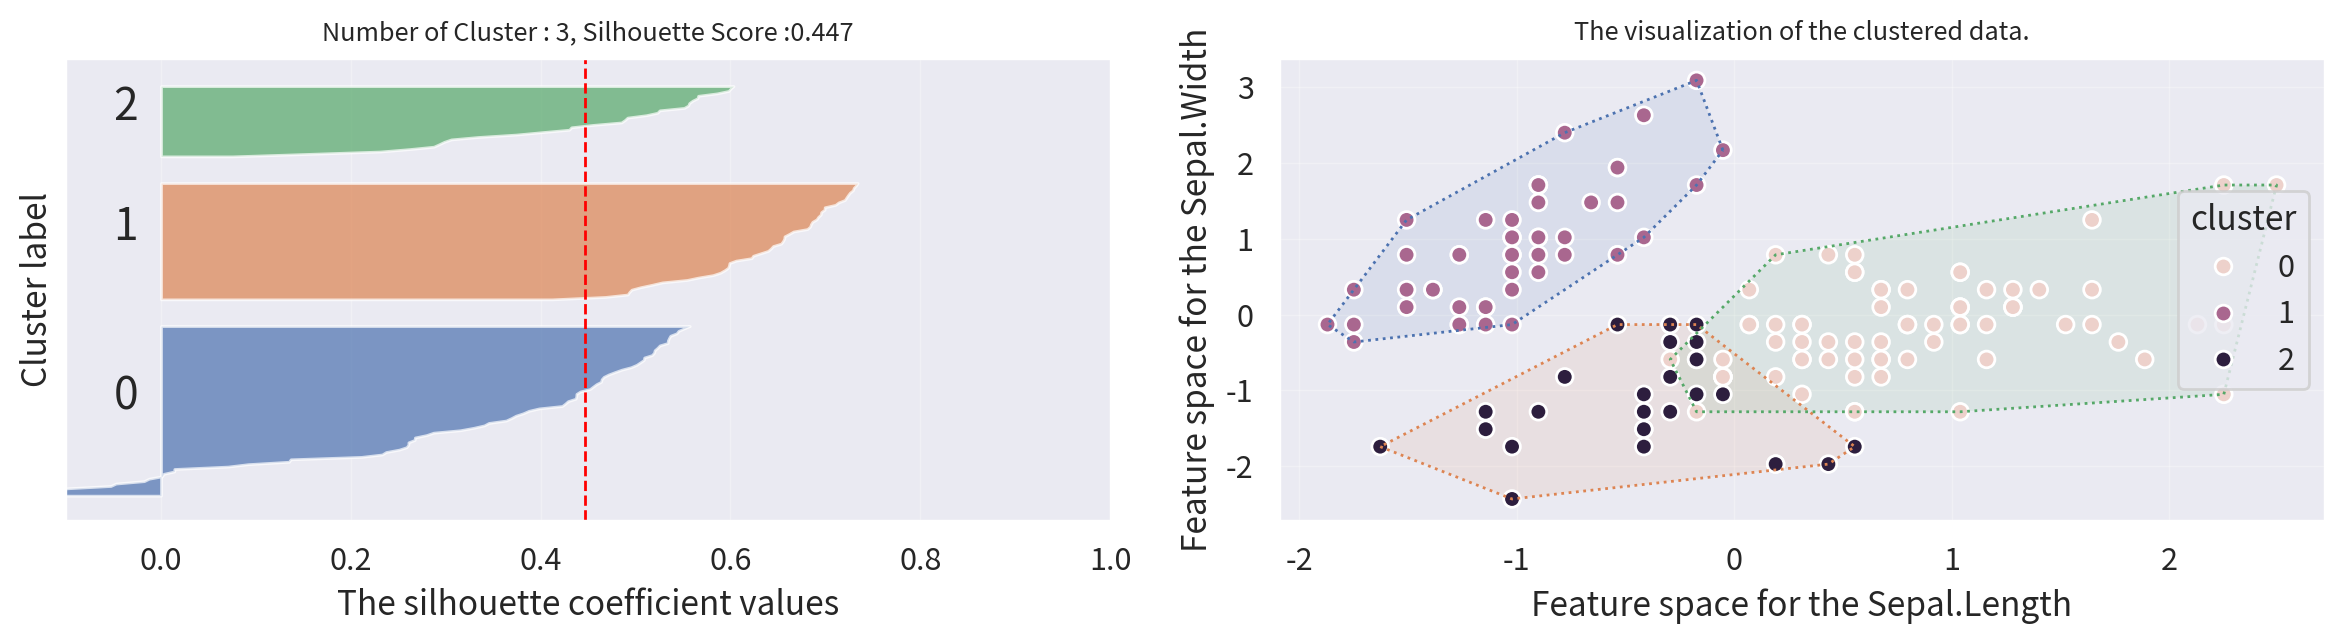

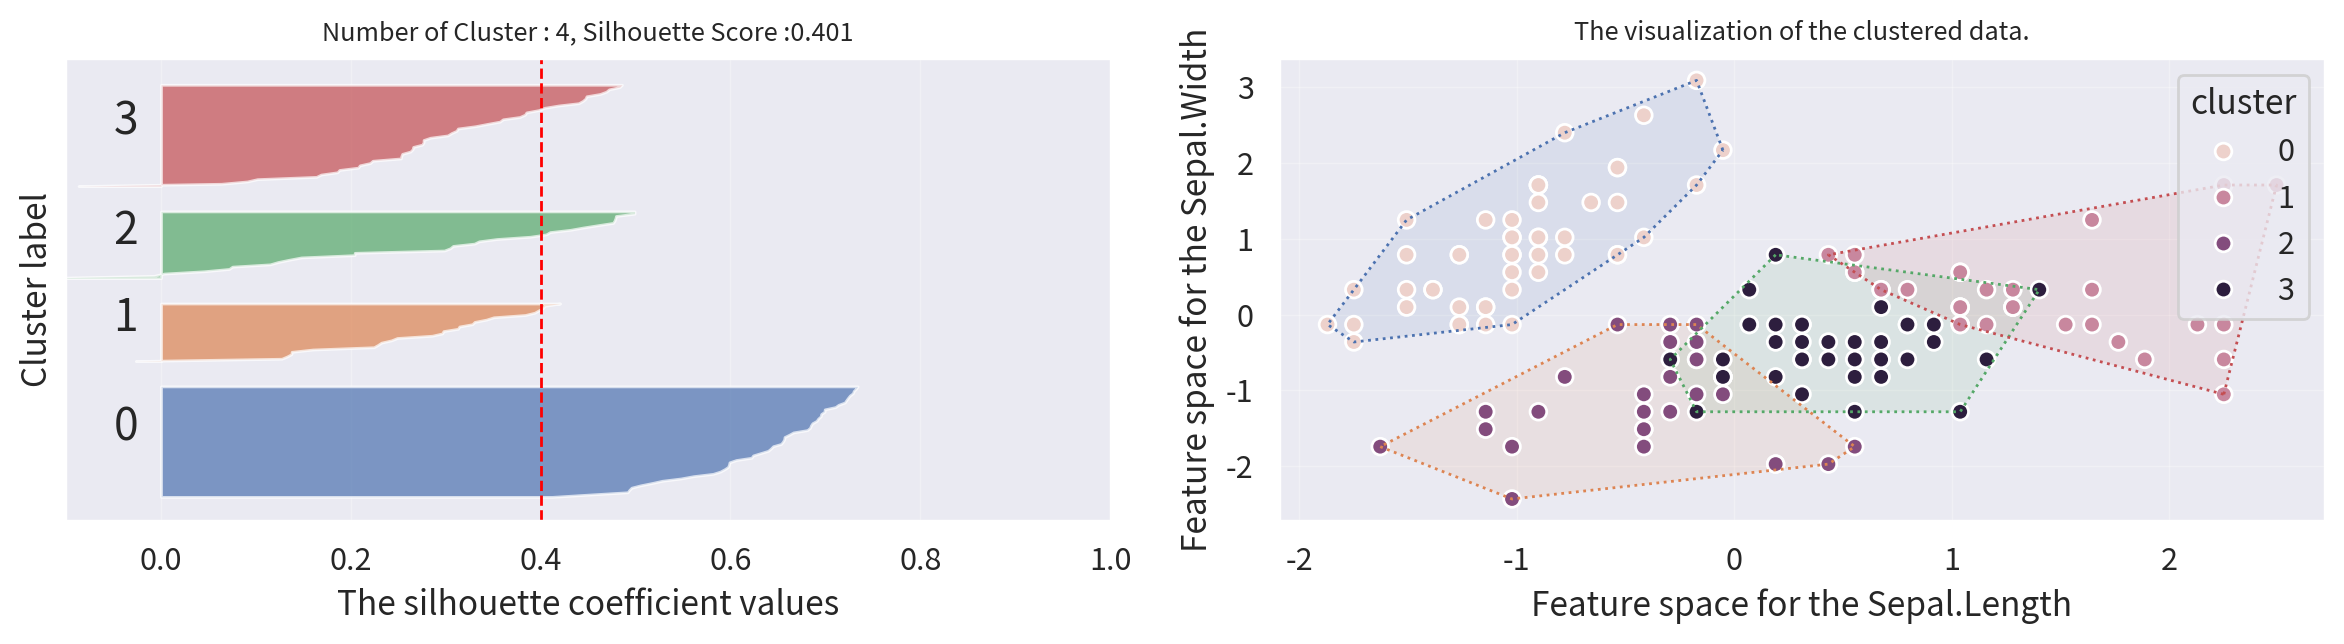

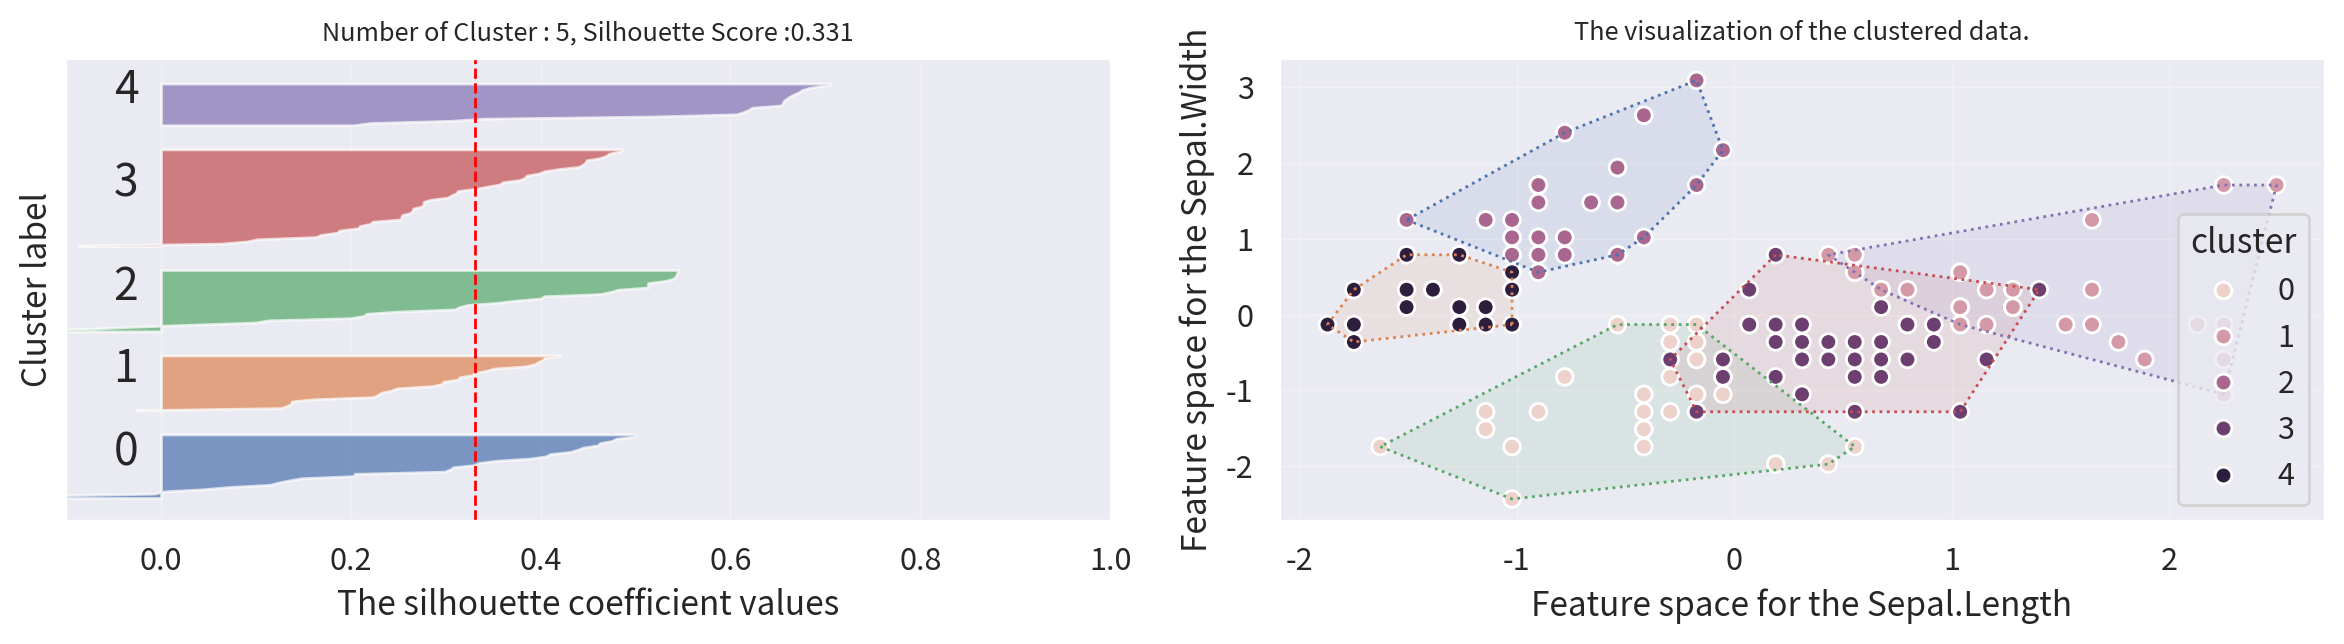

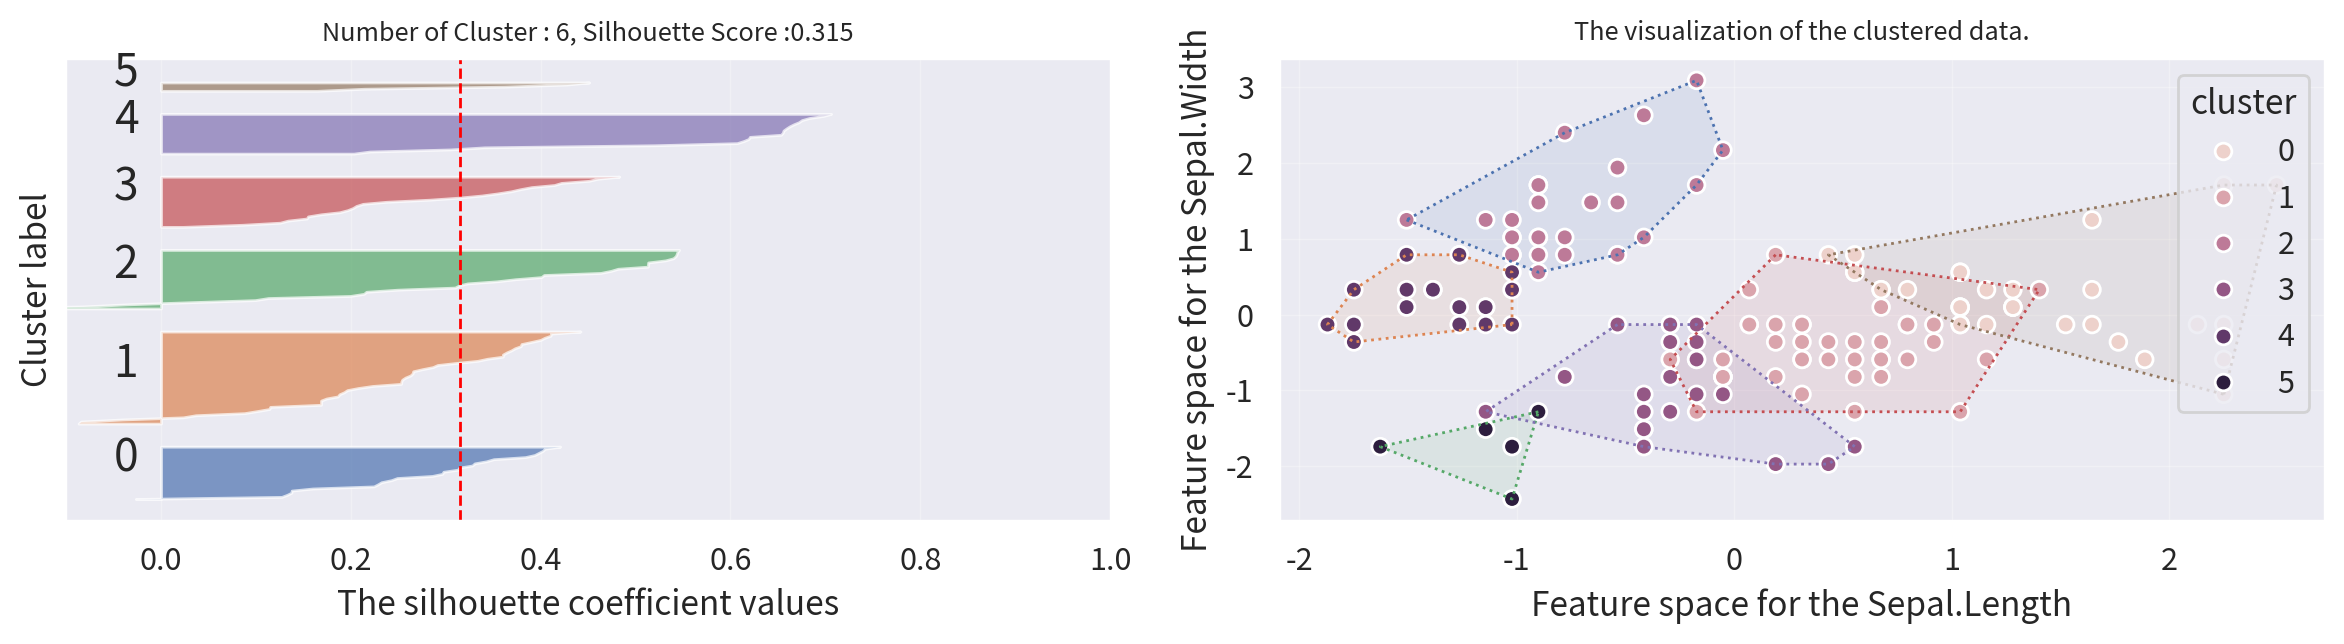

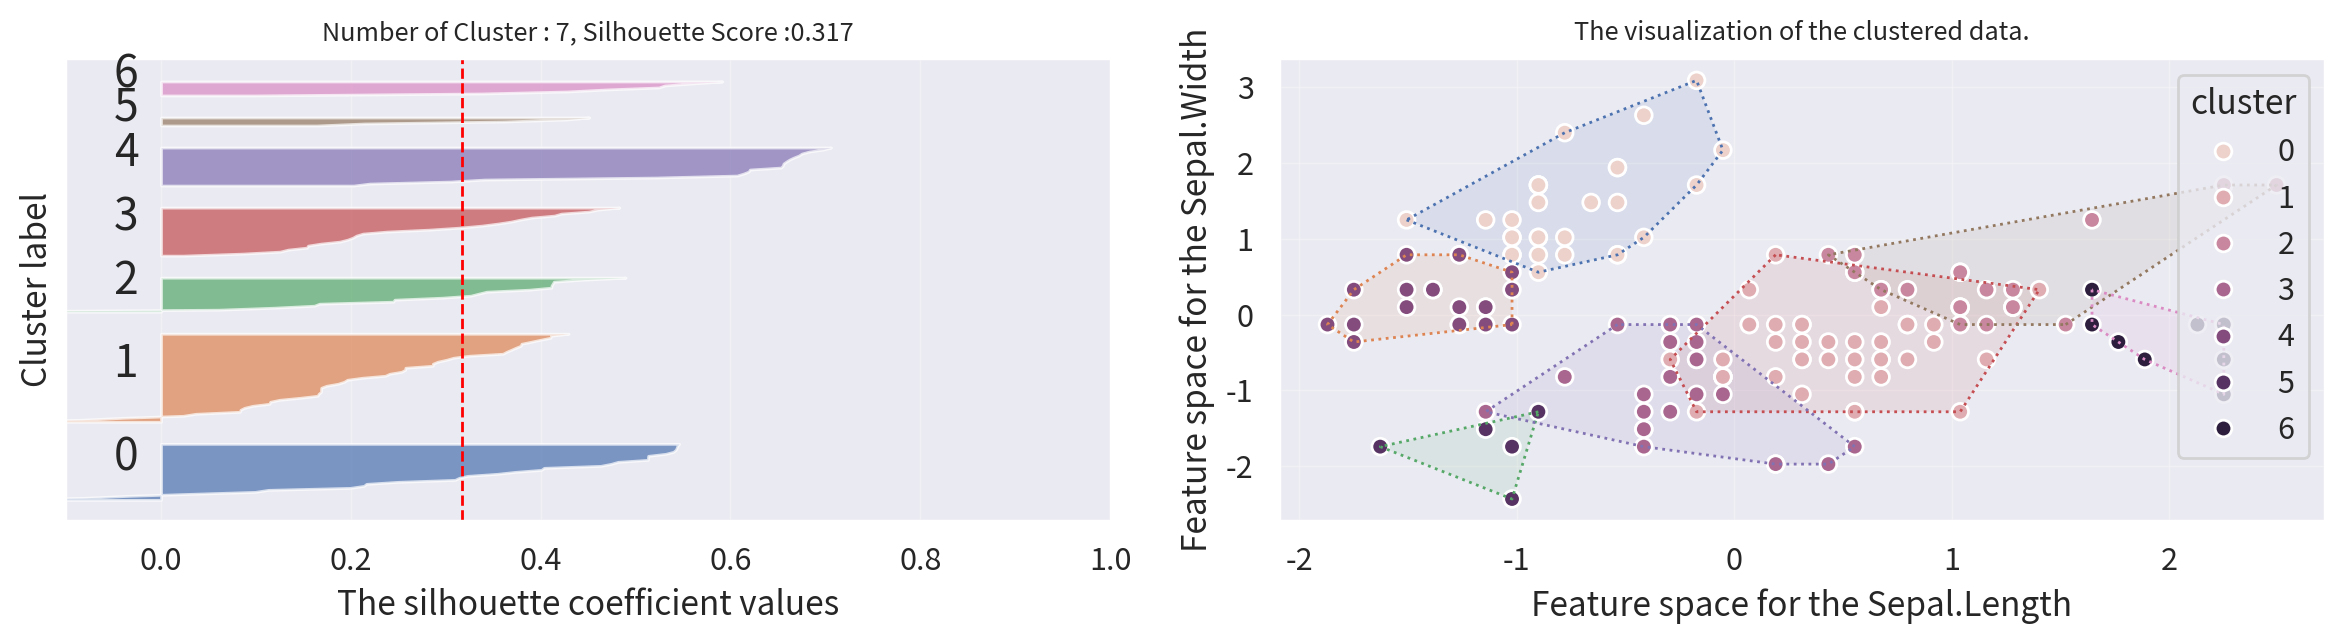

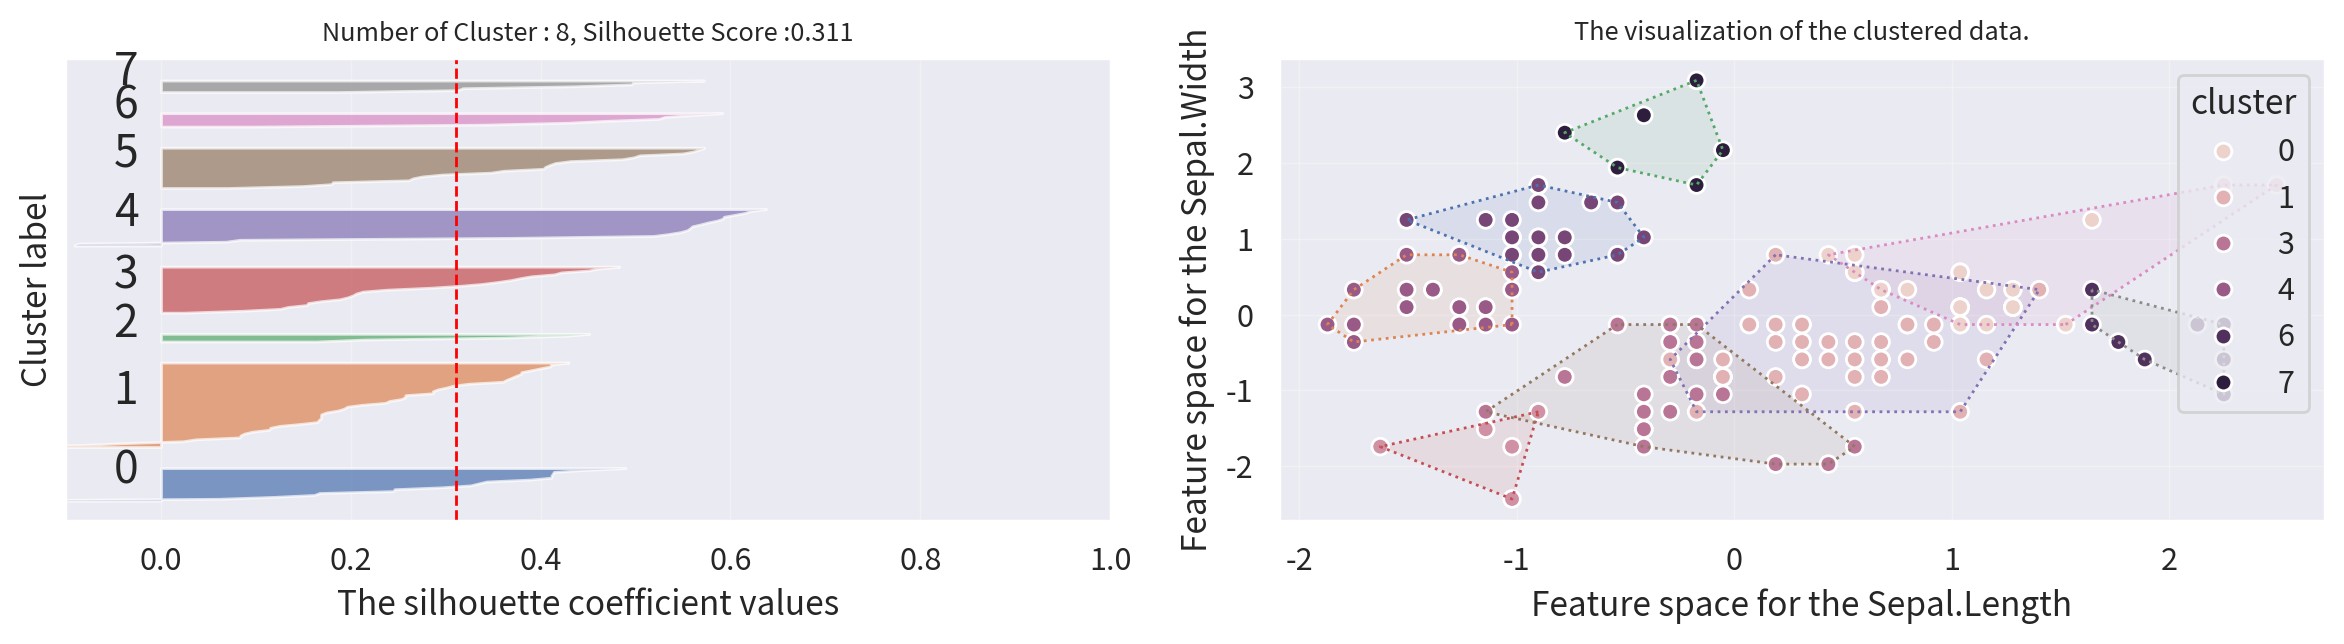

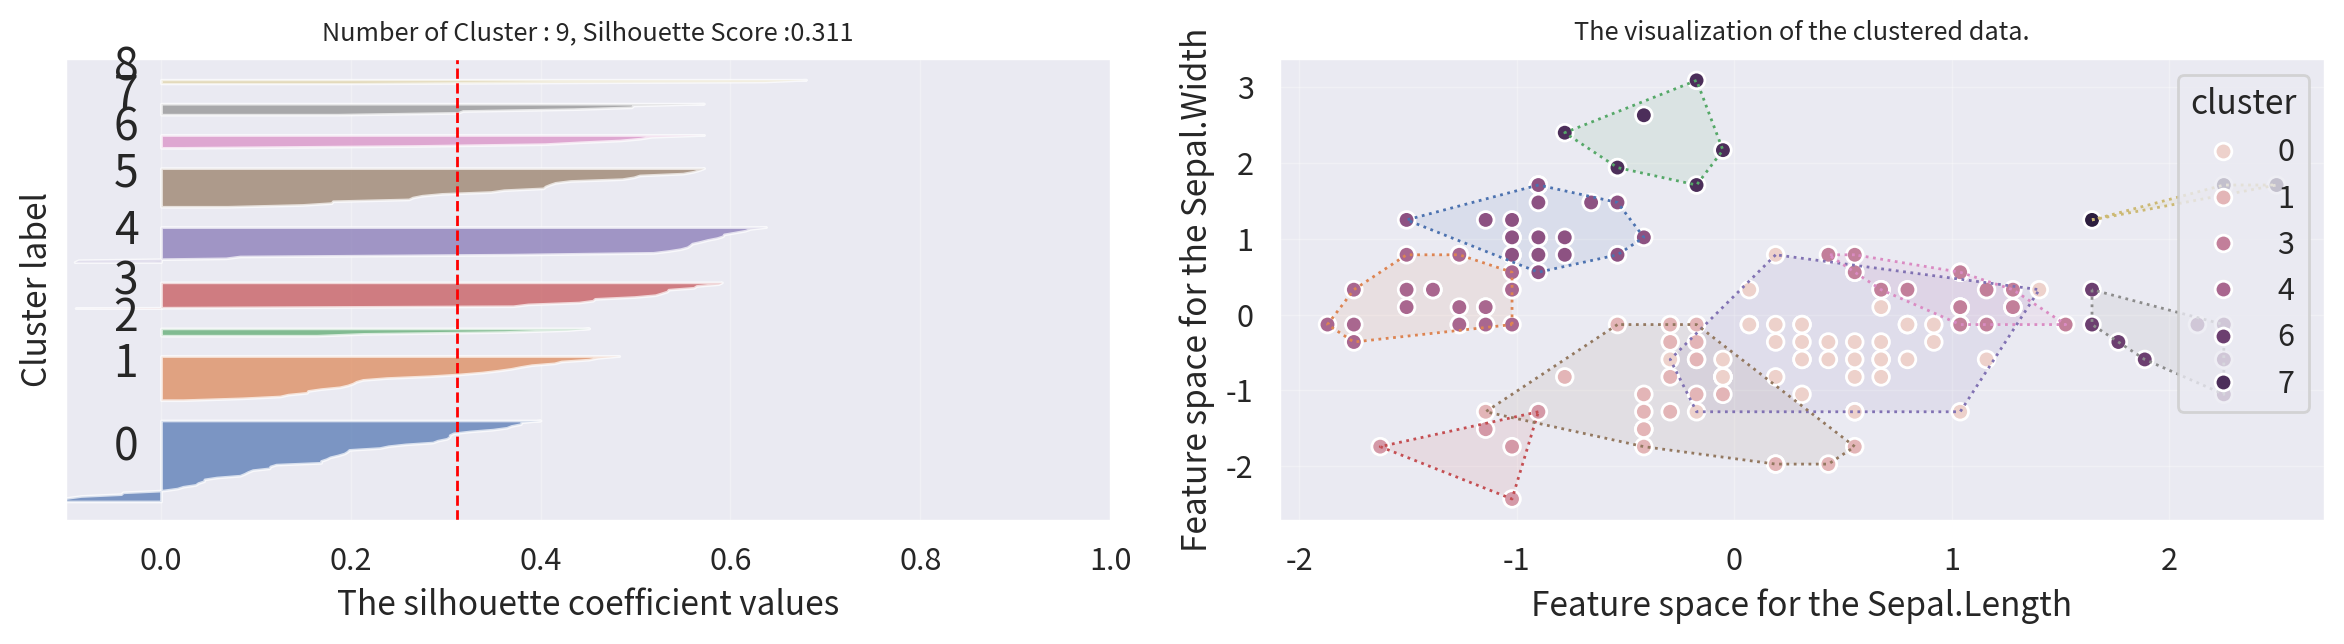

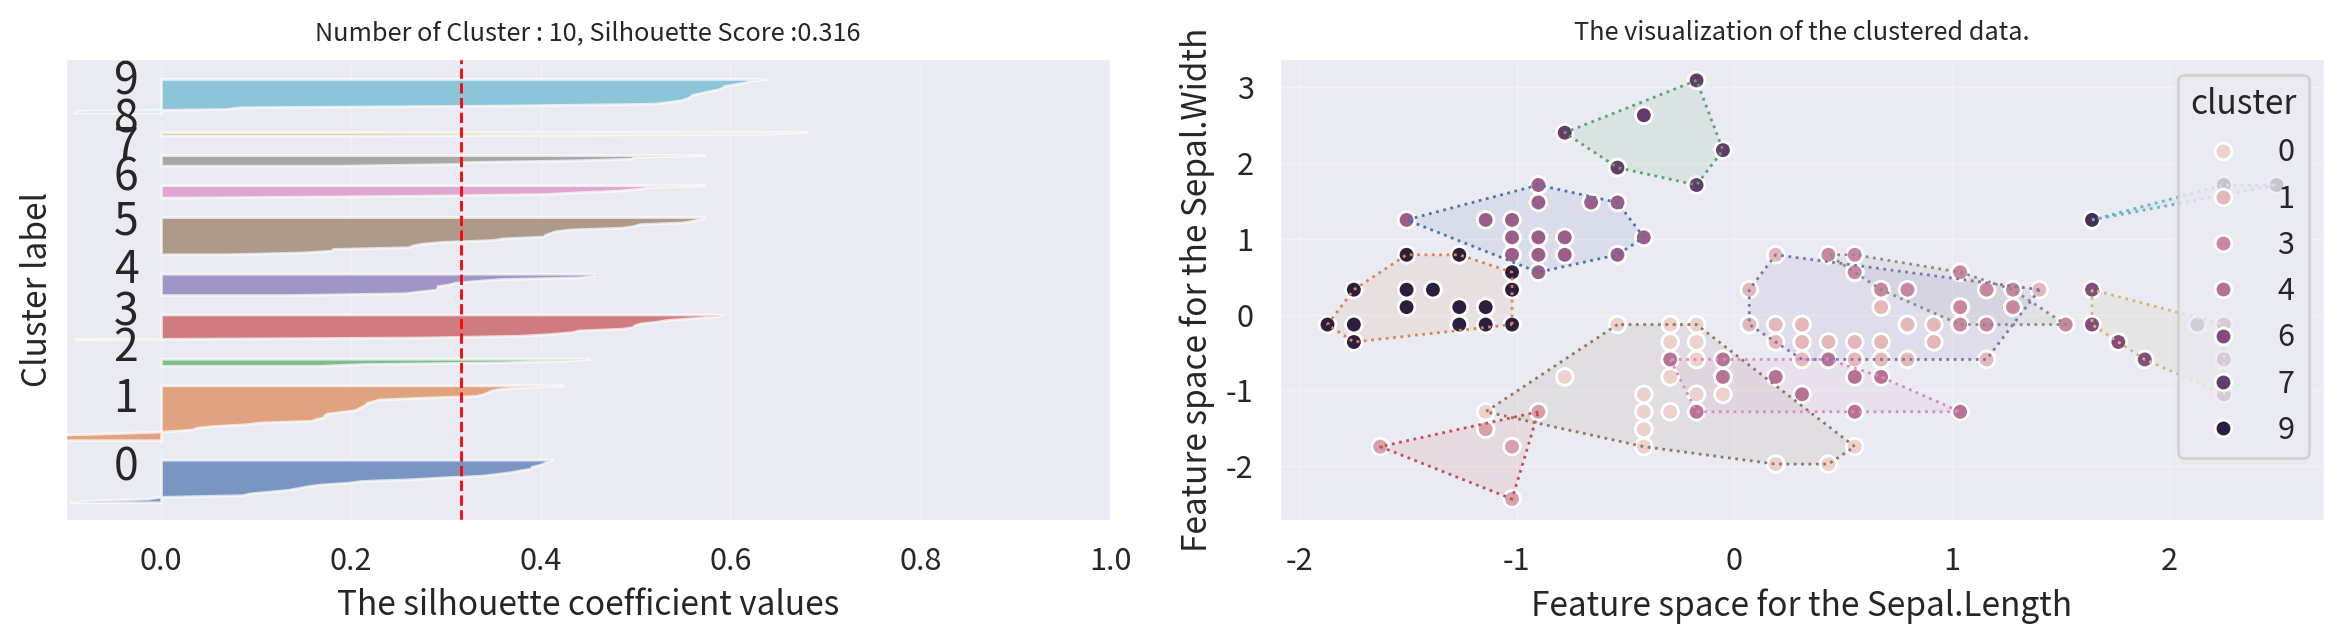

In [ ]:
#군집 k 를 바꿔가며 모델을 만들기 위한 준비 코드
klist = list(range(3,11))

s_items=[]


#모델 생성 > 학습 >평가>저장 반복

for k in klist:
  # 최종 군집 수를 k 개로 지정, 즉 덴드로그램을 k 개로 자른것과 동일함
  #distance 설정으로 군집 병합시 거리 정보 저장 
  estimator = AgglomerativeClustering(
    n_clusters=k,
    compute_distances=True   
    #군집이 병합될 떄마다 거리를 기록하게 되어서 estimator.distances_속성이 생김, 이는 덴드로그램의 y 축 높이 즉, 컷 높이 기준 설정에 쓰임

  )


  #군집에 사용할 데이터 적합
  estimator.fit(sdf)

  #각 샘플이 어느 군집에 속하는지 표기
  cluster = estimator.labels_

  #실루엣 시각화 (군집 간 분리도, 군집 크기 불균형 확인)
  visualize_silhouette(estimator,sdf) 

  #실루엣 스코어 계산 (0.7이상이면 잘 분리된 것, 0 이하는 잘못된 군집)
  s_score = silhouette_score(X=sdf , labels =cluster) 

  #군집수 (k) , 실루엣 스코어 , 예측 모형 저장
  s_items.append({'k':k , 'score':s_score})



#실루엣 스코어가 높은 k 를 내림차순으로 정렬
score_df =DataFrame(s_items)
score_df.sort_values(by='score',ascending=False,inplace=True)
score_df



> 최적의 군집수 3으로 판단

## #03. 최종 모형 적합

### [1] 최적 군집수 적용 모델

In [5]:
best_k=3

In [6]:
estimator = AgglomerativeClustering(
  n_clusters=best_k,
  compute_distances=True
)

#모델 학습
estimator.fit(sdf)

result_df = df.copy()
result_df['cluster'] = estimator.labels_
result_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


### [2] 군집 결과 시각화

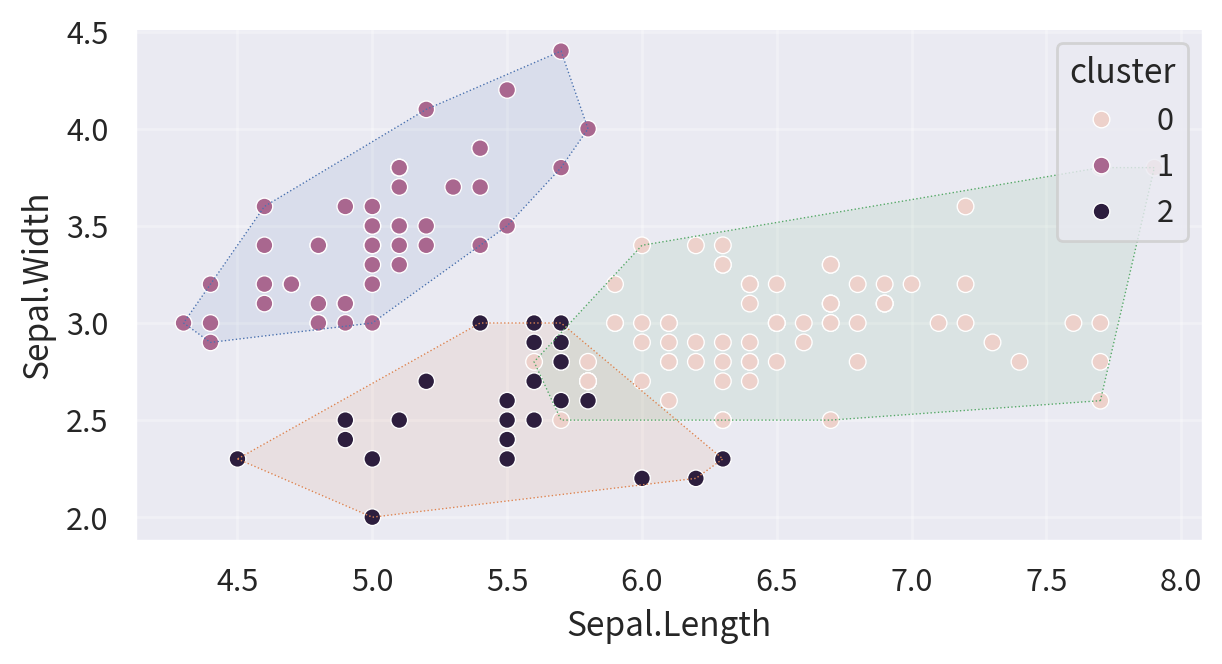

In [8]:
vdf=result_df.copy()

hue_field = 'cluster'
x_field = 'Sepal.Length'
y_field = 'Sepal.Width'

figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 군집별, 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 값의 종류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c)  # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0])  # 시작점과 끝점을 연결
        ax.plot(
            df_c.iloc[points, 0], df_c.iloc[points, 1],
            linewidth=0.5, linestyle=':'
        )
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass
sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field, ax=ax)

ax.legend(
    title='cluster',
    loc='upper right'   # 👈 우측 상단
)

ax.grid(True, alpha=0.3)  # 배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()


### [3] 최종 모형에 대한 실루엣 지수 확인


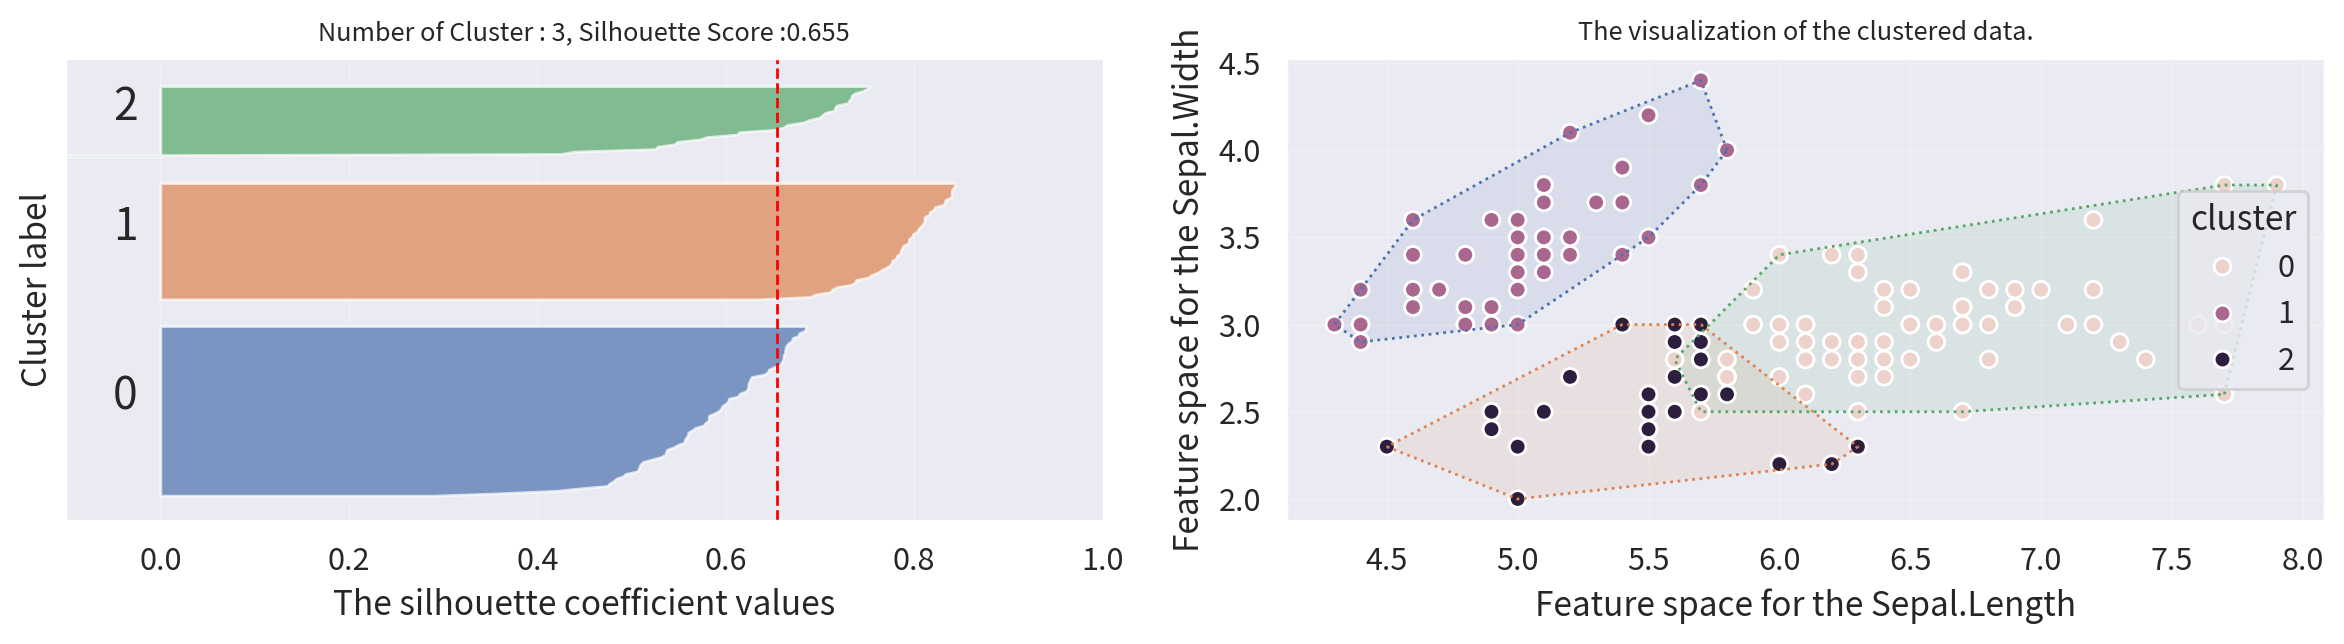

In [9]:
visualize_silhouette(estimator=estimator, data=result_df)

### [4] 덴드로그램

In [ ]:
import numpy as np

def dandrogram_source(estimator):
    counts = np.zeros(estimator.children_.shape[0])
    n_samples = len(estimator.labels_)

    for i, merge in enumerate(estimator.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [estimator.children_, estimator.distances_, counts]
    ).astype(float)

    # 시각화에 필요한 배열 리턴
    return linkage_matrix

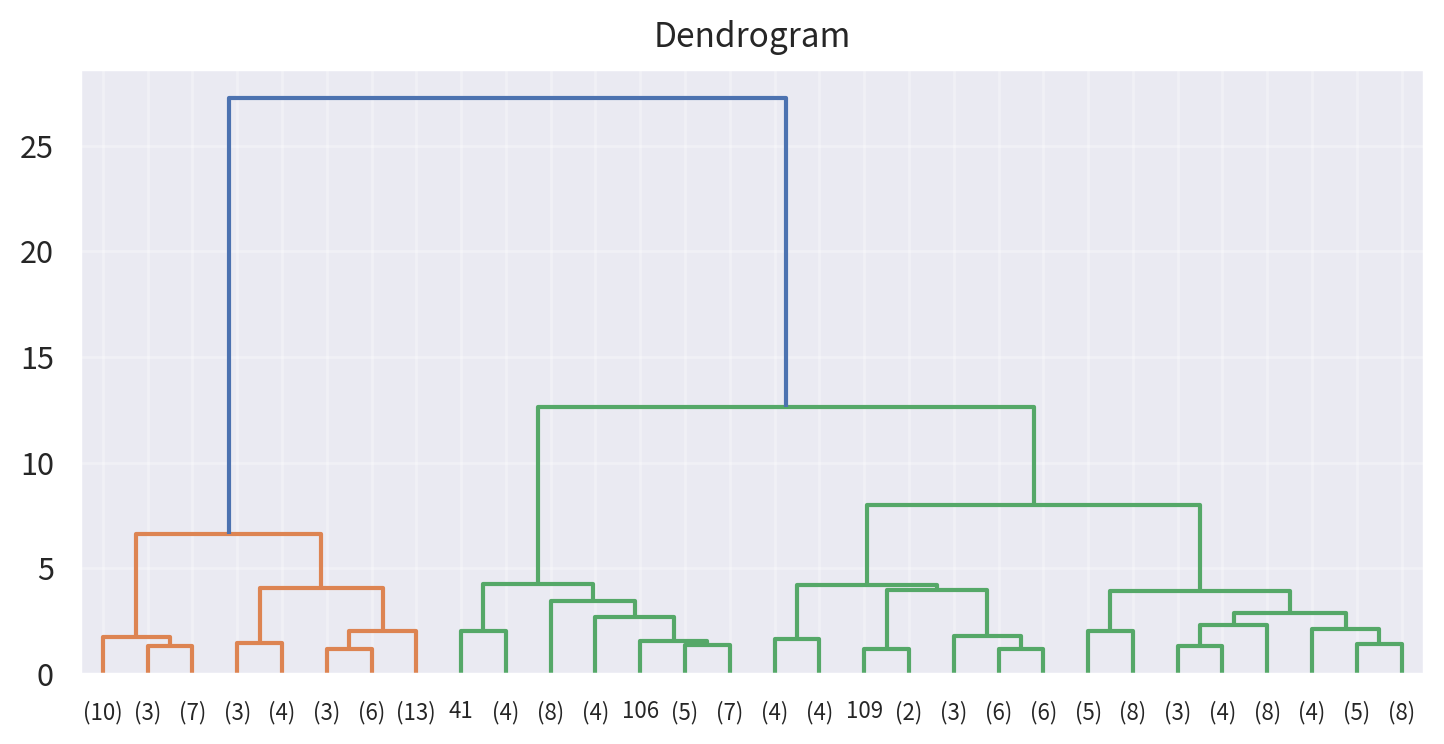

In [ ]:
from dandrogram_source import dandrogram_source

data = dandrogram_source(estimator)

figsize = (1500 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

dendrogram(
    data,
    ax=ax,
    p=30,                    #표시할 leaf, 말단 군집의 개수
    truncate_mode="lastp",   #마지막 p 개의 군집만 표시 , None 이면 전체 덴드로그램
    leaf_rotation=0,         # x 축 레이블의 회전 각도
    leaf_font_size=8,        #leaf 라벨의 글자 크기
    count_sort="ascending",  #leaf 군집의 정렬 기준 > 작은 군집 --> 큰 군집
)

ax.set_title("Dendrogram", fontsize=12, pad=8)
ax.grid(True, alpha=0.3)   # 배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()


<덴드로그램 인사이트>
(1) Y 축 : 군집 병합 거리 / X 축 : AKFEKS RNSWLQ
(2) 가장 큰 병합 지점 > Y 가 약 27 : 즉, 왼쪽 주황 군집과 오른쪽 초록 군집이 Y 27 지점에서 하나로 합쳐짐, 두 군집은 각 내부적으로는 꽤 응집되어 있지만 서로 간에는 이질적으로 멀다 (이 높이에서는 자르면 안되는 컷 높이)
(3) 자연스러운 컷 높이 후보
- Y가 13 인 지점에서 왼쪽 1개, 오른쪽 2개 총 3개 군집 으로 가장 자연스러움

- 두 개의 큰 군집이 가장 마지막에 결합됨 → 데이터가 두 개의 주요 그룹으로 나뉨  
- 중간 높이에서 여러 개의 소규모 군집이 결합됨 → 하위 그룹(서브클러스터) 존재  
- 군집 간 결합 거리가 급격히 증가하는 지점이 명확함 → 군집 간 분리가 뚜렷함  
- 약 **2~3개의 군집**으로 나누는 것이 적절함  
- 각 군집 내 데이터의 응집도가 높고, 군집 간 거리가 큼  
